# Modelagem Orientada a Objetos

Diante da necessidade de estruturar o código de maneira mais clara e adequada e também da possibilidade de adicionar novas funcionalidades, como validação e testes, foi lançado mão a orientação a objetos, a qual será abordada neste notebook.

In [38]:
!pip install plotly --quiet
!pip install wandb -qU --quiet

import torch
import torch.nn as nn
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

import torch.optim as optim

import matplotlib.pyplot as plt

import wandb

np.random.seed(1)

Em seguida, vamos conectar ao Google Drive, para conseguir exporar os modelos gerados.

In [39]:
from google.colab import drive

drive.mount('/content/gdrive')

wandb.login

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<function wandb.sdk.wandb_login.login(anonymous: Optional[Literal['must', 'allow', 'never']] = None, key: Optional[str] = None, relogin: Optional[bool] = None, host: Optional[str] = None, force: Optional[bool] = None, timeout: Optional[int] = None) -> bool>

Agora, vamos configurar o W&B para capturar a evolução do treinamento e sua otimização.

In [40]:
wandb.init(project='ic_pinn', entity='lucarvalho')

## Definição da Classe

Na abordagem orientada a objetos nesta implementação, a classe apresenta um cosntrutor que define os principais parâmetros da rede, ao passo que cada um dos métodos são, na realidade, passos pequenas passos na abordagem da solução.

In [41]:
class pinn:

  # Método contrutor
  def __init__(self, comprimento_x: int = 1, comprimento_y: int = 1, tempo_final: int = 1,
    pontos_no_contorno: int = 1000, pontos_no_dominio: int = 2000, numero_de_neuronios = [3, 20, 20, 20, 2],
    pontos_no_contorno_validacao: int = 200, pontos_no_dominio_validacao: int = 300,
    alpha: float = 0.2, epocas: int = 20000, learning_rate: float = 0.01,
    train: bool = False, verbose: bool = False, max_time = None,
    device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')):

    self.comprimento_x = comprimento_x
    self.comprimento_y = comprimento_y
    self.tempo_final = tempo_final
    self.alpha = alpha
    self.epocas = epocas
    self.learning_rate = learning_rate
    self.pontos_no_contorno = pontos_no_contorno
    self.pontos_no_dominio = pontos_no_dominio
    self.numero_de_neuronios = numero_de_neuronios
    self.learning_rate = learning_rate
    self.pontos_no_contorno_validacao = pontos_no_contorno_validacao
    self.pontos_no_dominio_validacao = pontos_no_dominio_validacao

    if type(device) == str:
      device = torch.device(device)
    self.device = device

    if train:
      self.treinamento_da_rede()

  # Método para geração de pontos no domínio
  def gerar_pontos_contorno(self):
    pontos_por_lado = self.pontos_no_contorno // 6
    pontos_por_lado_validacao = self.pontos_no_contorno_validacao // 6

    # Lado 1 (x = qualquer, y= 0, t = qualquer)
    x_lado1 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.comprimento_x)
    x_lado1_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.comprimento_x)
    y_lado1 = 0 * np.ones((pontos_por_lado,1))
    y_lado1_validacao = 0 * np.ones((pontos_por_lado_validacao,1))
    t_lado1 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.tempo_final)
    t_lado1_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.tempo_final)

    u_lado1_validacao = 0 * np.ones((pontos_por_lado_validacao,1))
    u_lado1 = 0 * np.ones((pontos_por_lado,1))
    v_lado1 = 0 * np.ones((pontos_por_lado,1))
    v_lado1_validacao = 0 * np.ones((pontos_por_lado_validacao,1))

    # Lado 2 (x = 0, y= qualquer, t = qualquer)
    x_lado2 = 0 * np.ones((pontos_por_lado,1))
    x_lado2_validacao = 0 * np.ones((pontos_por_lado_validacao,1))
    y_lado2 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.comprimento_y)
    y_lado2_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.comprimento_y)
    t_lado2 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.tempo_final)
    t_lado2_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.tempo_final)

    u_lado2 = 0 * np.ones((pontos_por_lado,1))
    u_lado2_validacao = 0 * np.ones((pontos_por_lado_validacao,1))
    v_lado2 = 0 * np.ones((pontos_por_lado,1))
    v_lado2_validacao = 0 * np.ones((pontos_por_lado_validacao,1))

    # Lado 3 (x = 1, y = qualquer, t = qualquer)
    x_lado3 = 1 * np.ones((pontos_por_lado,1))
    x_lado3_validacao = 1 * np.ones((pontos_por_lado_validacao,1))
    y_lado3 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.comprimento_y)
    y_lado3_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.comprimento_y)
    t_lado3 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.tempo_final)
    t_lado3_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.tempo_final)

    u_lado3 = 0 * np.ones((pontos_por_lado,1))
    u_lado3_validacao = 0 * np.ones((pontos_por_lado_validacao,1))
    v_lado3 = 0 * np.ones((pontos_por_lado,1))
    v_lado3_validacao = 0 * np.ones((pontos_por_lado_validacao,1))

    # Lado 4 (x = qualquer, y = 1, t = qualquer)
    x_lado4 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.comprimento_x)
    x_lado4_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.comprimento_x)
    y_lado4 = 1 * np.ones((pontos_por_lado,1))
    y_lado4_validacao = 1 * np.ones((pontos_por_lado_validacao,1))
    t_lado4 = np.random.uniform(size=(pontos_por_lado,1),low=0,high=self.tempo_final)
    t_lado4_validacao = np.random.uniform(size=(pontos_por_lado_validacao,1),low=0,high=self.tempo_final)

    u_lado4 = 0 * np.ones((pontos_por_lado,1))
    u_lado4_validacao = 0 * np.ones((pontos_por_lado_validacao,1))
    v_lado4 = 0 * np.ones((pontos_por_lado,1))
    v_lado4_validacao = 0 * np.ones((pontos_por_lado_validacao,1))

    # Condicao inicial (x = qualquer, y=qualquer, t = 0)
    x_inicial = np.random.uniform(size=(2*pontos_por_lado,1), low=0, high=self.comprimento_x)
    x_inicial_validacao = np.random.uniform(size=(2*pontos_por_lado_validacao,1), low=0, high=self.comprimento_x)
    y_inicial = np.random.uniform(size=(2*pontos_por_lado,1), low=0, high=self.comprimento_y)
    y_inicial_validacao = np.random.uniform(size=(2*pontos_por_lado_validacao,1), low=0, high=self.comprimento_y)
    t_inicial = 0 * np.ones((2*pontos_por_lado,1))
    t_inicial_validacao = 0 * np.ones((2*pontos_por_lado_validacao,1))

    # Modificação das condições iniciais para garantir u=0 nos contornos
    u_inicial = 0 * np.ones((2*pontos_por_lado,1))
    u_inicial_validacao = 0 * np.ones((2*pontos_por_lado_validacao,1))
    v_inicial = np.sin(np.pi * x_inicial / self.comprimento_x) * np.cos(np.pi * x_inicial / self.comprimento_y)
    v_inicial_validacao = np.sin(np.pi * x_inicial_validacao / self.comprimento_x) * np.cos(np.pi * x_inicial_validacao / self.comprimento_y)


    # Juntar todos os lados
    x_todos = np.vstack((x_lado1,x_lado2,x_lado3,x_lado4,x_inicial))
    y_todos = np.vstack((y_lado1,y_lado2,y_lado3,y_lado4,y_inicial))
    t_todos = np.vstack((t_lado1,t_lado2,t_lado3,t_lado4,t_inicial))
    u_todos = np.vstack((u_lado1,u_lado2,u_lado3,u_lado4,u_inicial))
    v_todos = np.vstack((v_lado1,v_lado2,v_lado3,v_lado4,v_inicial))

    # Juntar todo os lados em validação
    x_todos_validacao = np.vstack((x_lado1_validacao,x_lado2_validacao,x_lado3_validacao,x_lado4_validacao,x_inicial_validacao))
    y_todos_validacao = np.vstack((y_lado1_validacao,y_lado2_validacao,y_lado3_validacao,y_lado4_validacao,y_inicial_validacao))
    t_todos_validacao = np.vstack((t_lado1_validacao,t_lado2_validacao,t_lado3_validacao,t_lado4_validacao,t_inicial_validacao))
    u_todos_validacao = np.vstack((u_lado1_validacao,u_lado2_validacao,u_lado3_validacao,u_lado4_validacao,u_inicial_validacao))
    v_todos_validacao = np.vstack((v_lado1_validacao,v_lado2_validacao,v_lado3_validacao,v_lado4_validacao,v_inicial_validacao))


    # Criar arrays X e Y
    X_contorno = np.hstack((x_todos,y_todos,t_todos))
    Y_contorno = np.hstack((u_todos,v_todos))

    # Arrays X e Y para validação
    X_contorno_validacao = np.hstack((x_todos_validacao,y_todos_validacao,t_todos_validacao))
    Y_contorno_validacao = np.hstack((u_todos_validacao,v_todos_validacao))

    self.X_contorno = X_contorno
    self.Y_contorno = Y_contorno

    self.X_contorno_validacao = X_contorno_validacao
    self.Y_contorno_validacao = Y_contorno_validacao
    # X contorno - reúne os pontos
    # Y contorno - reúne velocidades

  def gerar_pontos_equacao(self):
    x_dominio = np.random.uniform(size=(self.pontos_no_dominio,1),low=0,high=self.comprimento_x)
    y_dominio = np.random.uniform(size=(self.pontos_no_dominio,1),low=0,high=self.comprimento_y)
    t_dominio = np.random.uniform(size=(self.pontos_no_dominio,1),low=0,high=self.tempo_final)

    x_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao,1),low=0,high=self.comprimento_x)
    y_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao,1),low=0,high=self.comprimento_y)
    t_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao,1),low=0,high=self.tempo_final)

    X_equacao = np.hstack((x_dominio,y_dominio,t_dominio))
    X_equacao_validacao = np.hstack((x_dominio_validacao,y_dominio_validacao,t_dominio_validacao))


    self.X_equacao = X_equacao
    self.X_equacao_validacao = X_equacao_validacao

  def criar_rede_neural(self):
    # Criar uma lista de todas as camadas
    camadas = []

    # Para cada camada, adicionar as conexões e a função de ativação
    for i in range(len(self.numero_de_neuronios)-1):
      camadas.append(nn.Linear(self.numero_de_neuronios[i],self.numero_de_neuronios[i+1]))
      camadas.append(nn.Tanh())

    # Remover a última camada, pois é a função de ativação
    camadas.pop()
    #camadas.pop()

    # Criar rede
    self.rna = nn.Sequential(*camadas)

  def calc_perda_contorno(self):
    Y_predito = self.rna(self.X_contorno)
    Y_predito_validacao = self.rna(self.X_contorno_validacao)

    perda_contorno = nn.functional.mse_loss(Y_predito, self.Y_contorno)
    perda_contorno_validacao = nn.functional.mse_loss(Y_predito_validacao, self.Y_contorno_validacao)

    self.perda_contorno = perda_contorno
    self.perda_contorno_validacao = perda_contorno_validacao

  def calc_residuo(self):
    x = self.X_equacao[:,0].reshape(-1, 1)
    y = self.X_equacao[:,1].reshape(-1, 1)
    t = self.X_equacao[:,2].reshape(-1, 1)

    x_validacao = self.X_equacao_validacao[:,0].reshape(-1, 1)
    y_validacao = self.X_equacao_validacao[:,1].reshape(-1, 1)
    t_validacao = self.X_equacao_validacao[:,2].reshape(-1, 1)

    # Dois valores preditos pela rede - velocidade u(x,y,t) e velocidade v(x,y,t)
    V = self.rna(torch.hstack((x, y, t)))
    u = V[:,0].reshape(-1,1)
    v = V[:,1].reshape(-1,1)

    V_validacao = self.rna(torch.hstack((x_validacao, y_validacao, t_validacao)))
    u_validacao = V_validacao[:,0].reshape(-1,1)
    v_validacao = V_validacao[:,1].reshape(-1,1)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]

    u_x_validacao = torch.autograd.grad(u_validacao, x_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]
    u_xx_validacao = torch.autograd.grad(u_x_validacao, x_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]
    u_y_validacao = torch.autograd.grad(u_validacao, y_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]
    u_yy_validacao = torch.autograd.grad(u_y_validacao, y_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]

    v_x_validacao = torch.autograd.grad(v_validacao, x_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]
    v_xx_validacao = torch.autograd.grad(v_x_validacao, x_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]
    v_y_validacao = torch.autograd.grad(v_validacao, y_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]
    v_yy_validacao = torch.autograd.grad(v_y_validacao, y_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(u),retain_graph=True, create_graph=True)[0]

    u_t_validacao = torch.autograd.grad(u_validacao, t_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]
    v_t_validacao = torch.autograd.grad(v_validacao, t_validacao, grad_outputs=torch.ones_like(u_validacao),retain_graph=True, create_graph=True)[0]

    residual_u = (u_t + u * u_x + v * u_y - 0.01/np.pi * (u_xx + u_yy))
    residual_v = (v_t + u * v_x + v * v_y - 0.01/np.pi * (u_xx + u_yy))

    residual_u_validacao = (u_t_validacao + u_validacao * u_x_validacao + v_validacao * u_y_validacao - 0.01/np.pi * (u_xx_validacao + u_yy_validacao))
    residual_v_validacao = (v_t_validacao + u_validacao * v_x_validacao + v_validacao * v_y_validacao - 0.01/np.pi * (u_xx_validacao + u_yy_validacao))

    residuo_total = torch.cat((residual_u, residual_v), dim=1)
    self.residuo_total = residuo_total

    residuo_total_validacao = torch.cat((residual_u_validacao, residual_v_validacao), dim=1)
    self.residuo_total_validacao = residuo_total_validacao

  def calc_perda_equacao(self):
    self.calc_residuo()
    residuo = torch.mean(torch.square(self.residuo_total))
    residuo_validacao = torch.mean(torch.square(self.residuo_total_validacao))

    self.perda_equacao = residuo
    self.perda_equacao_validacao = residuo_validacao

  def calc_perda(self):

    self.calc_perda_contorno()
    self.calc_perda_equacao()

    perda = (1-self.alpha)*self.perda_contorno + self.alpha*self.perda_equacao
    perda_validacao = (1-self.alpha)*self.perda_contorno_validacao + self.alpha*self.perda_equacao_validacao

    self.perda = perda
    self.perda_validacao = perda_validacao
    self.perda_contorno = self.perda_contorno
    self.perda_contorno_validacao = self.perda_contorno_validacao
    self.perda_equacao = self.perda_equacao
    self.perda_equacao_validacao = self.perda_equacao_validacao

  def definicao_otimizador(self):
      otimizador = torch.optim.Adam(self.rna.parameters(),self.learning_rate)
      agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

      self.X_equacao = torch.tensor(self.X_equacao,requires_grad=True,dtype=torch.float)
      self.X_contorno = torch.tensor(self.X_contorno,dtype=torch.float)
      self.Y_contorno = torch.tensor(self.Y_contorno,dtype=torch.float)

      self.X_equacao = self.X_equacao.to(self.device)
      self.X_contorno = self.X_contorno.to(self.device)
      self.Y_contorno = self.Y_contorno.to(self.device)
      self.rna = self.rna.to(self.device)

      self.X_equacao_validacao = torch.tensor(self.X_equacao_validacao,requires_grad=True,dtype=torch.float)
      self.X_contorno_validacao = torch.tensor(self.X_contorno_validacao,dtype=torch.float)
      self.Y_contorno_validacao = torch.tensor(self.Y_contorno_validacao,dtype=torch.float)

      self.X_equacao_validacao = self.X_equacao_validacao.to(self.device)
      self.X_contorno_validacao = self.X_contorno_validacao.to(self.device)
      self.Y_contorno_validacao = self.Y_contorno_validacao.to(self.device)
      self.rna = self.rna.to(self.device)

  def calcular_grid(self,nx=101, ny=101, nt=101):

    # Definir grid
    x = np.linspace(0.,self.comprimento_x,nx)
    y = np.linspace(0.,self.comprimento_y,ny)
    t = np.linspace(0.,self.tempo_final,nt)
    [t_grid, y_grid, x_grid] = np.meshgrid(t,y,x)
    x = torch.tensor(x_grid.flatten()[:,None],requires_grad=True,dtype=torch.float).to(self.device)
    y = torch.tensor(y_grid.flatten()[:,None],requires_grad=True,dtype=torch.float).to(self.device)
    t = torch.tensor(t_grid.flatten()[:,None],requires_grad=True,dtype=torch.float).to(self.device)

    # Avaliar modelor
    self.rna.eval()
    Y_pred = self.rna(torch.hstack((x,y,t)))

    # Formatar resultados em array
    u_pred = Y_pred.cpu().detach().numpy()[:,0].reshape(x_grid.shape)
    v_pred = Y_pred.cpu().detach().numpy()[:,1].reshape(x_grid.shape)
    self.x_grid = x_grid
    self.y_grid = y_grid
    self.t_grid = t_grid
    self.u_pred = u_pred
    self.v_pred = v_pred

  def treinamento_da_rede(self):
    otimizador = torch.optim.Adam(self.rna.parameters(),self.learning_rate)
    agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

    perda_historico = np.zeros(self.epocas)
    perda_contorno_historico = np.zeros(self.epocas)
    perda_equacao_historico = np.zeros(self.epocas)

    perda_historico_validacao = np.zeros(self.epocas)
    perda_contorno_historico_validacao = np.zeros(self.epocas)
    perda_equacao_historico_validacao = np.zeros(self.epocas)

    epocas = np.array(range(self.epocas))

    # Colocar rede em modo de treinamento
    self.rna.train()

    # FAZER ITERAÇÃO
    for epoca in epocas:
      # Resortear pontos
      #X_equacao = gerar_pontos_equacao(pontos_no_dominio,comprimento_x,tempo_final)
      #X_equacao = torch.tensor(X_equacao,requires_grad=True,dtype=torch.float).to(device)

      # Inicializar gradientes
      otimizador.zero_grad()

      # Calcular perdas
      self.calc_perda()

      # Backpropagation
      self.perda.backward()

      # Passo do otimizador
      otimizador.step()
      agendador.step()

      # Guardar logs
      perda_historico[epoca] = self.perda.item()
      perda_contorno_historico[epoca] = self.perda_contorno.item()
      perda_equacao_historico[epoca] = self.perda_equacao.item()

      perda_historico_validacao[epoca] = self.perda_validacao.item()
      perda_contorno_historico_validacao[epoca] = self.perda_contorno_validacao.item()
      perda_equacao_historico_validacao[epoca] = self.perda_equacao_validacao.item()

      for name, param in self.rna.named_parameters():
        wandb.log({f'Gradient/{name}': param.grad.norm().item()}, step=epoca)

      if epoca%500==0:
        print(f'Epoca: {epoca}, Perda: {self.perda.item()} (Contorno: {self.perda_contorno.item()}, Equacao: {self.perda_equacao.item()})')
        print(f'Perda Validação: {self.perda_validacao.item()} (Contorno Validação: {self.perda_contorno_validacao.item()}, Equacao: {self.perda_equacao_validacao.item()})')
        wandb.log({'epoch': epoca, 'loss': self.perda.item()})
    self.perda_historico = perda_historico
    self.perda_contorno_historico = perda_contorno_historico
    self.perda_equacao_historico = perda_equacao_historico

    self.perda_historico_validacao = perda_historico_validacao
    self.perda_contorno_historico_validacao = perda_contorno_historico_validacao
    self.perda_equacao_historico_validacao = perda_equacao_historico_validacao

  def plot_historico(self):
    # Plotar histórico
    epocas = np.array(range(self.epocas))
    fig = go.FigureWidget()
    fig.add_trace(go.Scatter(x=epocas, y=self.perda_historico, name='Total', line=dict(color='black', width=4)))
    fig.add_trace(go.Scatter(x=epocas, y=self.perda_contorno_historico, name='Contorno', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=epocas, y=self.perda_equacao_historico, name='Equacao', line=dict(color='red', width=2)))
    fig.update_yaxes(type="log")
    fig.show(renderer="colab")

  def plot_comparacao(self):
    # Plotar histórico
    epocas = np.array(range(self.epocas))
    plt.plot(epocas, self.perda_historico, 'b', label="Perda do treino")
    plt.plot(epocas, self.perda_historico_validacao, 'r', label="Perdas nos pontos de validação")
    plt.xlabel('Épocas')
    plt.ylabel('Perdas')
    plt.yscale('log')
    plt.legend()
    plt.show()

  def plot_resultados(self):
    # Calcular valores da função e gerar grids
    epocas = np.array(range(self.epocas))
    self.calcular_grid()

    # Plotar figura
    fig = go.Figure(data=[go.Surface(x=self.x_grid, y=self.t_grid, z=self.u_pred)])

    fig.update_layout(scene=dict(aspectratio=dict(x=1.5, y=1.5, z=0.5)))
    fig.show()

    ind_t_plot = 0 # Esse é o índice do tempo a ser plotado

    # Extrair uma "fatia" dos arrays de coordenadas e soluções
    x_plot = self.x_grid[:,ind_t_plot,:]
    y_plot = self.y_grid[:,ind_t_plot,:]
    u_plot = self.u_pred[:,ind_t_plot,:]

    fig = go.Figure(data=[go.Surface(x=x_plot, y=y_plot, z=u_plot)])

    fig.update_layout(scene=dict(aspectratio=dict(x=1.5, y=1.5, z=0.5)))
    fig.show()

## Medição de Qualidade da Rede

Agora que o código está montado e estruturado na forma Orientada a Objetos, um bom ponto de continuidade é a elaboração de uma função de medição de qualidade da rede. Basicamente, vai ser uma rotina de testes automatizados, que vai gerar diversos modelos. A ideia é comparar como variações nos hiperparâmetros da rede impactam o resultado final, tentando indicar um ponto ótimo para a rede.

In [42]:
def medicao_qualidade(comprimento_x: int = 1, comprimento_y: int = 1, tempo_final: int = 1,
    pontos_no_contorno: int = 1000, pontos_no_dominio: int = 2000, numero_de_neuronios = [3, 20, 20, 20, 2],
    pontos_no_contorno_validacao: int = 200, pontos_no_dominio_validacao: int = 300,
    alpha: float = 0.2, epocas: int = 20000, learning_rate: float = 0.01,
    train: bool = False, verbose: bool = False, max_time = None,
    device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')):

    # Criação do Objeto
    pinn_burgers = pinn(comprimento_x, comprimento_y, tempo_final, pontos_no_contorno, pontos_no_dominio, numero_de_neuronios, pontos_no_contorno_validacao, pontos_no_dominio_validacao, alpha, epocas, learning_rate, train, verbose, max_time, device)

    # Pontos de contorno e domínio para o treinamento e para a validação
    pinn_burgers.gerar_pontos_contorno()
    pinn_burgers.gerar_pontos_equacao()

    # Criação da rede
    pinn_burgers.criar_rede_neural()

    # Passando para GPU e otimizando
    pinn_burgers.definicao_otimizador()

    # Treinamento
    pinn_burgers.treinamento_da_rede()

    save_path = '/content/gdrive/My Drive/IC/models/pinn_burgers_model.pth'
    torch.save(pinn_burgers.rna.state_dict(), save_path)

    return pinn_burgers

### Modelando e Resolvendo

Epoca: 0, Perda: 0.02716943621635437 (Contorno: 0.02980327047407627, Equacao: 0.003464928362518549)
Perda Validação: 0.02671605721116066 (Contorno Validação: 0.02929803542792797, Equacao: 0.0034782637376338243)
Epoca: 500, Perda: 0.002937551587820053 (Contorno: 0.002371755428612232, Equacao: 0.008029715158045292)
Perda Validação: 0.0034024445340037346 (Contorno Validação: 0.003048310987651348, Equacao: 0.006589647848159075)
Epoca: 1000, Perda: 0.002043801127001643 (Contorno: 0.001556857954710722, Equacao: 0.006426289677619934)
Perda Validação: 0.0026052696630358696 (Contorno Validação: 0.002265965100377798, Equacao: 0.005659011192619801)
Epoca: 1500, Perda: 0.0017281882464885712 (Contorno: 0.0013038951437920332, Equacao: 0.005546825937926769)
Perda Validação: 0.002433875110000372 (Contorno Validação: 0.002086482010781765, Equacao: 0.005560414865612984)
Epoca: 2000, Perda: 0.0015648561529815197 (Contorno: 0.0011360680218786001, Equacao: 0.0054239495657384396)
Perda Validação: 0.00232572

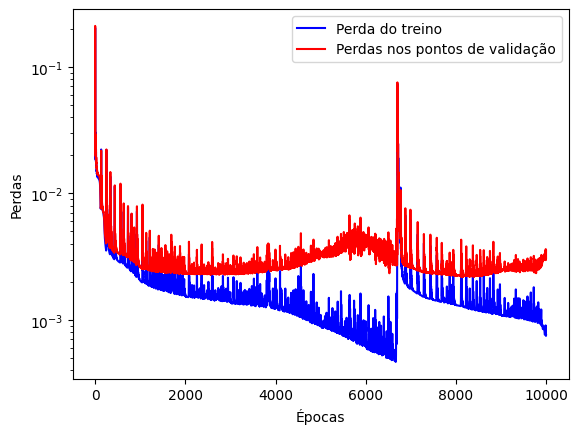

In [43]:
pinn_burgers = medicao_qualidade(1, 1, 1, 1000, 2000, [3, 20, 20, 20, 2], 200, 300, 0.1, 10000, 0.05, False, False, None, 'cuda')
pinn_burgers.plot_historico()
pinn_burgers.plot_comparacao()